<a href="https://colab.research.google.com/github/MarvinLok/Algo-Trading/blob/main/Pair_Trading_Cointegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://palomar.home.ece.ust.hk/MAFS5310_lectures/slides_pairs_trading.pdf

https://blog.quantinsti.com/mean-reversion-strategies-introduction-building-blocks/

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
!pip install yfinance
import yfinance as yf
!pip install mplfinance
import mplfinance as mpf
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.2 MB/s eta 0:00:00


In [2]:
# start_date = "2015-01-01"
# end_date = "2025-01-01"

# stock_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol
# price_data = pd.DataFrame()
# for stock in stock_list:
#     data = yf.download(stock, start=start_date, end=end_date, interval="1d", auto_adjust=True, multi_level_index=False)['Close']
#     price_data[stock] = data

# price_data = price_data.dropna(axis=1, how='any')
# price_data.to_csv('sp500_close_2015_2024.csv')

In [2]:
uploaded = files.upload()

Saving sp500_close_2015_2024.csv to sp500_close_2015_2024.csv


In [3]:
csv_file = 'sp500_close_2015_2024.csv'
raw_price_data = pd.read_csv(csv_file, index_col=0, parse_dates=True)

In [4]:
raw_price_data

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,96.967499,23.600349,36.580616,42.394863,74.623970,72.339996,2.670000,9.239816,23.804163,37.195496,...,24.674276,100.274788,80.410004,126.556221,25.937885,33.335350,42.624203,77.430000,100.454254,39.889095
2015-01-05,94.780594,23.187407,36.588757,41.597019,73.364014,71.980003,2.660000,8.976782,23.180613,36.498531,...,23.697559,99.554512,80.010002,124.402321,25.643465,31.260647,41.758167,76.339996,104.201561,39.649628
2015-01-06,93.769959,22.997801,36.173260,41.391144,72.834816,70.529999,2.630000,8.774451,22.974051,35.929958,...,23.375628,99.059334,79.419998,121.748672,25.779898,31.076813,41.245617,75.790001,103.318268,39.262817
2015-01-07,94.449646,23.166344,36.466553,43.064018,74.363586,71.110001,2.580000,8.787941,23.118254,36.406830,...,23.250135,100.477386,79.349998,125.324196,26.002508,31.321922,42.612427,77.720001,105.887825,40.073288
2015-01-08,96.713364,23.768881,37.216103,43.514416,75.497543,72.919998,2.610000,8.922830,23.344290,37.498119,...,23.473852,101.625313,82.779999,126.831993,26.304119,31.558279,43.354744,79.379997,107.012016,40.690388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,129.087891,67.866943,113.126747,175.172623,358.322815,447.940002,126.290001,12.422579,102.101891,135.276016,...,53.663708,313.332642,269.040008,88.309021,66.534340,117.409760,133.709183,395.440002,106.553841,163.105942
2024-12-26,129.899887,67.866943,113.629479,174.394058,357.133789,450.160004,125.059998,12.250837,102.517273,135.007660,...,53.034687,315.156982,269.380005,88.836212,66.505081,117.727753,134.699615,396.850006,106.504188,163.918030
2024-12-27,128.909638,67.413780,113.353470,173.235962,352.922638,446.480011,125.190002,12.164967,102.240356,134.719391,...,53.015026,313.610291,266.239990,88.209557,66.466064,116.793640,133.936981,389.070007,106.126823,163.006927


In [5]:
price_data = raw_price_data.apply(np.log)

In [6]:
price_data

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,4.574376,3.161262,3.599518,3.747027,4.312462,4.281377,0.982079,2.223522,3.169860,3.616188,...,3.205761,4.607914,4.387139,4.840687,3.255705,3.506618,3.752422,4.349374,4.609702,3.686103
2015-01-05,4.551565,3.143609,3.599741,3.728029,4.295434,4.276388,0.978326,2.194641,3.143316,3.597272,...,3.165372,4.600705,4.382152,4.823521,3.244289,3.442360,3.731895,4.335197,4.646327,3.680082
2015-01-06,4.540845,3.135399,3.588320,3.723067,4.288194,4.256038,0.966984,2.171844,3.134365,3.581571,...,3.151694,4.595719,4.374750,4.801959,3.249595,3.436462,3.719545,4.327966,4.637814,3.670278
2015-01-07,4.548067,3.142701,3.596395,3.762688,4.308966,4.264228,0.947789,2.173380,3.140623,3.594756,...,3.146311,4.609933,4.373868,4.830904,3.258193,3.444318,3.752146,4.353113,4.662380,3.690710
2015-01-08,4.571752,3.168377,3.616742,3.773092,4.324100,4.289363,0.959350,2.188613,3.150352,3.624291,...,3.155887,4.621293,4.416186,4.842863,3.269726,3.451836,3.769416,4.374246,4.672941,3.705992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,4.860493,4.217549,4.728509,5.165772,5.881434,6.104659,4.838581,2.519516,4.625971,4.907317,...,3.982737,5.747265,5.594860,4.480842,4.197718,4.765670,4.895667,5.979999,4.668650,5.094400
2024-12-26,4.866764,4.217549,4.732943,5.161317,5.878110,6.109603,4.828794,2.505594,4.630031,4.905332,...,3.970946,5.753071,5.596123,4.486794,4.197278,4.768375,4.903047,5.983558,4.668184,5.099366
2024-12-27,4.859112,4.210849,4.730511,5.154655,5.866249,6.101395,4.829833,2.498560,4.627326,4.903194,...,3.970575,5.748151,5.584398,4.479715,4.196692,4.760409,4.897369,5.963759,4.664635,5.093793


https://medium.com/@johnswyou/pairwise-correlation-and-cointegration-among-listed-us-equities-12cc14293baa

In [7]:
corr_matrix = price_data.corr(method='pearson')

In [8]:
corr_matrix

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
MMM,1.000000,0.096899,-0.036759,-0.146005,-0.070346,0.051552,-0.013011,-0.075819,-0.121479,-0.000425,...,-0.252946,-0.047808,0.051678,0.503874,0.005921,0.090586,-0.055746,0.108627,0.196270,-0.039048
AOS,0.096899,1.000000,0.770514,0.881060,0.873818,0.823340,0.850394,0.669737,0.873100,0.865184,...,0.575786,0.840593,0.782420,0.140695,0.736827,0.904819,0.859208,0.729419,0.479313,0.806259
ABT,-0.036759,0.770514,1.000000,0.884885,0.964003,0.963364,0.949102,0.915215,0.823268,0.963726,...,0.476304,0.954156,0.950741,-0.066491,0.940320,0.924795,0.948445,0.965732,0.633683,0.987693
ABBV,-0.146005,0.881060,0.884885,1.000000,0.937167,0.856788,0.889542,0.791685,0.934905,0.925978,...,0.690484,0.924523,0.815392,-0.067691,0.831551,0.900696,0.920797,0.806386,0.415684,0.890750
ACN,-0.070346,0.873818,0.964003,0.937167,1.000000,0.958187,0.964761,0.876386,0.899570,0.976343,...,0.541324,0.965788,0.924228,-0.090456,0.927892,0.955203,0.964849,0.913358,0.577320,0.976793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.090586,0.904819,0.924795,0.900696,0.955203,0.948041,0.954330,0.848802,0.897987,0.961489,...,0.490421,0.949599,0.921818,0.099781,0.900705,1.000000,0.962078,0.887798,0.619557,0.942414
YUM,-0.055746,0.859208,0.948445,0.920797,0.964849,0.933521,0.948452,0.877722,0.926292,0.956819,...,0.572300,0.960781,0.926632,0.036083,0.917534,0.962078,1.000000,0.894746,0.592050,0.958126
ZBRA,0.108627,0.729419,0.965732,0.806386,0.913358,0.931681,0.902488,0.908278,0.737189,0.931675,...,0.430718,0.900797,0.926745,-0.000746,0.890533,0.887798,0.894746,1.000000,0.667082,0.951370
ZBH,0.196270,0.479313,0.633683,0.415684,0.577320,0.635818,0.620149,0.695093,0.390986,0.628210,...,0.068277,0.587424,0.662831,0.315618,0.631029,0.619557,0.592050,0.667082,1.000000,0.632743


In [9]:
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        ticker1 = corr_matrix.columns[i]
        ticker2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        if corr_value >= 0.99:
            high_corr_pairs.append((ticker1, ticker2))
high_corr_pairs

[('ACN', 'HD'),
 ('A', 'MTD'),
 ('LNT', 'AEE'),
 ('LNT', 'CMS'),
 ('GOOGL', 'GOOG'),
 ('AEP', 'CMS'),
 ('AJG', 'LIN'),
 ('AJG', 'MMC'),
 ('AJG', 'SNPS'),
 ('AZO', 'ORLY'),
 ('BRO', 'CTAS'),
 ('BRO', 'MMC'),
 ('BRO', 'RSG'),
 ('CDNS', 'LIN'),
 ('CDNS', 'MSFT'),
 ('CDNS', 'SNPS'),
 ('CTAS', 'MSI'),
 ('CMS', 'WEC'),
 ('CPRT', 'MSFT'),
 ('CPRT', 'V'),
 ('INTU', 'MSFT'),
 ('KLAC', 'SNPS'),
 ('LIN', 'SNPS'),
 ('MMC', 'RSG'),
 ('MLM', 'VMC'),
 ('MA', 'ROP'),
 ('MA', 'V'),
 ('MPWR', 'SNPS'),
 ('MCO', 'SPGI'),
 ('MCO', 'NOW'),
 ('MSI', 'RSG'),
 ('MSCI', 'SPGI'),
 ('MSCI', 'TMO'),
 ('MSCI', 'ZTS'),
 ('NWSA', 'NWS'),
 ('RSG', 'WM'),
 ('ROP', 'V'),
 ('WEC', 'XEL')]

In [10]:
tickers_in_pairs = sorted(set(ticker for pair in high_corr_pairs for ticker in pair))
filtered_price_data = price_data[tickers_in_pairs]
filtered_price_data

,A,ACN,AEE,AEP,AJG,AZO,BRO,CDNS,CMS,CPRT,...,RSG,SNPS,SPGI,TMO,V,VMC,WEC,WM,XEL,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,3.616188,4.312462,3.507573,3.738653,3.650013,6.424529,2.689669,2.935451,3.244351,1.520060,...,3.512598,3.763523,4.380604,4.821293,4.120185,4.117497,3.631208,3.738458,3.255705,3.686103
2015-01-05,3.597272,4.295434,3.497520,3.723825,3.644035,6.410980,2.676686,2.912351,3.236064,1.510170,...,3.506913,3.750445,4.362737,4.807460,4.097864,4.089488,3.618913,3.728359,3.244289,3.680082
2015-01-06,3.581571,4.288194,3.485812,3.729288,3.642106,6.409879,2.671695,2.885359,3.237785,1.498786,...,3.510378,3.741472,4.348164,4.798078,4.091399,4.087182,3.621574,3.729140,3.249595,3.670278
2015-01-07,3.594756,4.308966,3.493560,3.743384,3.651714,6.408924,2.680722,2.913437,3.253981,1.501853,...,3.506913,3.742657,4.361359,4.827595,4.104709,4.105934,3.633837,3.729920,3.258193,3.690710
2015-01-08,3.624291,4.324100,3.497081,3.751973,3.668989,6.406880,2.699753,2.923699,3.259321,1.512101,...,3.516044,3.757939,4.370287,4.837935,4.118032,4.136720,3.644839,3.741353,3.269726,3.705992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,4.907317,5.881434,4.495042,4.507611,5.660277,8.096659,4.640182,5.731981,4.186687,4.079400,...,5.311163,6.214928,6.220402,6.269069,5.767010,5.573097,4.536996,5.317696,4.197718,5.094400
2024-12-26,4.905332,5.878110,4.492839,4.504249,5.660312,8.083714,4.639122,5.732338,4.188631,4.078723,...,5.310967,6.206213,6.220462,6.265661,5.767820,5.574004,4.535205,5.315941,4.197278,5.099366
2024-12-27,4.903194,5.866249,4.486534,4.509125,5.653981,8.083829,4.630895,5.720410,4.190273,4.068343,...,5.304972,6.196261,6.214541,6.263553,5.760784,5.565692,4.534678,5.311052,4.196692,5.093793


In [11]:
rolling_window = 252
rolling_params = pd.DataFrame(index = filtered_price_data.index)

In [25]:
for ticker1, ticker2 in high_corr_pairs:
    rolling_mu = [np.nan] * rolling_window
    rolling_hedge_ratio = [np.nan] * rolling_window
    for i in range(rolling_window, len(filtered_price_data)):
        past_data = filtered_price_data.iloc[i-rolling_window:i]
        y = past_data[ticker1]  # Dependent variable
        X = past_data[ticker2]  # Independent variable
        X = sm.add_constant(X)   # Add constant for intercept
        model = sm.OLS(y, X).fit()
        rolling_mu.append(model.params[0])
        rolling_hedge_ratio.append(model.params[1])
    rolling_params[f"{ticker1}_{ticker2}_mu"] = rolling_mu
    rolling_params[f"{ticker1}_{ticker2}_hedge_ratio"] = rolling_hedge_ratio

串流輸出內容已截斷至最後 5000 行。
/tmp/ipython-input-1409728065.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_mu.append(model.params[0])
/tmp/ipython-input-1409728065.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_hedge_ratio.append(model.params[1])
/tmp/ipython-input-1409728065.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_mu.append(model.params[0])
/tmp/ipython-input-1409728065.py:11: FutureWarning: 

In [28]:
# rolling_params.to_csv('rolling_params_2015_2024.csv')

In [12]:
uploaded = files.upload()

Saving rolling_params_2015_2024.csv to rolling_params_2015_2024.csv


In [13]:
rolling_params = 'rolling_params_2015_2024.csv'
rolling_params = pd.read_csv(rolling_params, index_col=0, parse_dates=True)

In [16]:
rolling_params

,ACN_HD_mu,ACN_HD_hedge_ratio,A_MTD_mu,A_MTD_hedge_ratio,LNT_AEE_mu,LNT_AEE_hedge_ratio,LNT_CMS_mu,LNT_CMS_hedge_ratio,GOOGL_GOOG_mu,GOOGL_GOOG_hedge_ratio,...,MSCI_ZTS_mu,MSCI_ZTS_hedge_ratio,NWSA_NWS_mu,NWSA_NWS_hedge_ratio,RSG_WM_mu,RSG_WM_hedge_ratio,ROP_V_mu,ROP_V_hedge_ratio,WEC_XEL_mu,WEC_XEL_hedge_ratio
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,1.696844,0.698931,2.894780,0.281152,-0.035368,0.921276,-0.741986,1.140000,-0.015349,1.001245,...,3.127316,0.611764,0.623932,0.797884,-0.742744,1.127479,5.411315,0.157350,1.077728,0.827576
2024-12-26,1.672289,0.703057,2.882881,0.282793,-0.025576,0.918963,-0.761071,1.144622,-0.016065,1.001386,...,3.179929,0.601741,0.640872,0.792765,-0.747607,1.128434,5.467264,0.147362,1.078657,0.827411
2024-12-27,1.649777,0.706837,2.870972,0.284434,-0.017472,0.917040,-0.778248,1.148782,-0.016514,1.001475,...,3.226720,0.592844,0.655196,0.788437,-0.750206,1.128966,5.522186,0.137557,1.079838,0.827175


In [60]:
df_spread = pd.DataFrame(index = rolling_params.index)
df_residual = pd.DataFrame(index = rolling_params.index)
df_sd = pd.DataFrame(index = rolling_params.index)
df_z_score = pd.DataFrame(index = rolling_params.index)

for ticker1, ticker2 in high_corr_pairs:
      df_spread[f"{ticker1}_{ticker2}_spread"]  = filtered_price_data[ticker1] - rolling_params[f"{ticker1}_{ticker2}_hedge_ratio"] * filtered_price_data[ticker2]
      df_residual[f"{ticker1}_{ticker2}_residual"]  = df_spread[f"{ticker1}_{ticker2}_spread"] - rolling_params[f"{ticker1}_{ticker2}_mu"]
      df_sd[f"{ticker1}_{ticker2}_sd"] = np.nan

      for i in range(rolling_window,len(filtered_price_data)):
          df_spread_temp = df_spread[f"{ticker1}_{ticker2}_spread"].iloc[i-rolling_window:i]
          temp_hedge_ratio = rolling_params[f"{ticker1}_{ticker2}_hedge_ratio"].iloc[i]
          df_spread_temp = filtered_price_data[f"{ticker1}"].iloc[i-rolling_window:i]- temp_hedge_ratio * filtered_price_data[f"{ticker2}"].iloc[i-rolling_window:i]
          df_spread_temp_sd = df_spread_temp.std()
          df_sd[f"{ticker1}_{ticker2}_sd"].iloc[i] = df_spread_temp_sd

      df_z_score[f"{ticker1}_{ticker2}_z_score"] = df_residual[f"{ticker1}_{ticker2}_residual"] / df_sd[f"{ticker1}_{ticker2}_sd"]


In [19]:
df_residual_drop_nan = df_residual.dropna()
df_residual_drop_nan

,ACN_HD_residual,A_MTD_residual,LNT_AEE_residual,LNT_CMS_residual,GOOGL_GOOG_residual,AEP_CMS_residual,AJG_LIN_residual,AJG_MMC_residual,AJG_SNPS_residual,AZO_ORLY_residual,...,MCO_SPGI_residual,MCO_NOW_residual,MSI_RSG_residual,MSCI_SPGI_residual,MSCI_TMO_residual,MSCI_ZTS_residual,NWSA_NWS_residual,RSG_WM_residual,ROP_V_residual,WEC_XEL_residual
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.057072,0.010545,0.006571,0.004241,-0.014082,0.013208,-0.039926,-0.076515,-0.094074,0.010438,...,-0.025724,-0.070220,-0.015007,0.154465,0.042534,0.115537,-0.035534,0.038595,0.041822,-0.012554
2016-01-05,-0.046727,0.002534,0.004685,0.003381,-0.012133,0.015483,-0.034054,-0.084023,-0.090304,0.009539,...,-0.013966,-0.055262,-0.044651,0.157980,0.052003,0.109535,-0.022587,0.052216,0.042050,-0.013379
2016-01-06,-0.039090,0.022222,0.002533,0.003802,-0.016269,0.018124,-0.046661,-0.087079,-0.104079,0.016732,...,-0.024965,-0.065111,-0.062576,0.151235,0.055721,0.101094,-0.037011,0.048255,0.029637,-0.028040
2016-01-07,-0.043692,0.000217,-0.008272,-0.011020,-0.016096,0.001774,-0.051010,-0.097037,-0.115601,0.028608,...,-0.047684,-0.102778,-0.086168,0.142046,0.074993,0.109142,-0.040794,0.058207,0.012401,-0.032144
2016-01-08,-0.042753,-0.005708,-0.003887,-0.009726,-0.012417,0.001773,-0.060469,-0.087658,-0.115537,0.012359,...,-0.057456,-0.127124,-0.082070,0.130727,0.061330,0.105101,-0.027224,0.060795,0.007647,-0.023598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.012502,0.008506,-0.042491,0.032477,0.001333,-0.040586,0.145297,0.067548,0.067711,0.010993,...,0.016083,-0.060490,0.083712,0.056239,0.098109,0.159855,-0.031566,0.058319,-0.053880,-0.014665
2024-12-26,0.010881,0.006954,-0.039358,0.030490,0.001084,-0.045747,0.148183,0.066181,0.062852,0.007166,...,0.017552,-0.053866,0.080706,0.060781,0.101495,0.160338,-0.029360,0.059883,-0.054053,-0.016324
2024-12-27,0.003068,0.007564,-0.034888,0.026511,0.002107,-0.042297,0.144173,0.064825,0.050833,0.013212,...,0.015081,-0.052324,0.082605,0.061726,0.097672,0.159958,-0.033538,0.059178,-0.057794,-0.016559


In [74]:
cointegrated_pairs = []

# Run ADF test with maxlag=1 for each spread
for column in df_residual_drop_nan.columns:

    tickers = column.replace('_residual', '').split('_')
    ticker1, ticker2 = tickers[0], tickers[1]

    spread = df_residual_drop_nan[column]

    # Run ADF test (Dickey-Fuller with maxlag=1)
    adf_result = adfuller(spread, maxlag=1)
    p_value = adf_result[1]

    # Determine if stationary (p-value < 0.05)
    cointegrated_pairs.append((ticker1, ticker2)) if p_value < 0.01 else "Not Stationary"
    stationary = "Stationary" if p_value < 0.05 else "Not Stationary"

    print(f"{tickers}, ADF p-value: {p_value:.6f}, {stationary}")

['ACN', 'HD'], ADF p-value: 0.000000, Stationary
['A', 'MTD'], ADF p-value: 0.000256, Stationary
['LNT', 'AEE'], ADF p-value: 0.000000, Stationary
['LNT', 'CMS'], ADF p-value: 0.000006, Stationary
['GOOGL', 'GOOG'], ADF p-value: 0.000000, Stationary
['AEP', 'CMS'], ADF p-value: 0.000013, Stationary
['AJG', 'LIN'], ADF p-value: 0.000004, Stationary
['AJG', 'MMC'], ADF p-value: 0.000137, Stationary
['AJG', 'SNPS'], ADF p-value: 0.000006, Stationary
['AZO', 'ORLY'], ADF p-value: 0.000001, Stationary
['BRO', 'CTAS'], ADF p-value: 0.000053, Stationary
['BRO', 'MMC'], ADF p-value: 0.000197, Stationary
['BRO', 'RSG'], ADF p-value: 0.000058, Stationary
['CDNS', 'LIN'], ADF p-value: 0.000002, Stationary
['CDNS', 'MSFT'], ADF p-value: 0.000289, Stationary
['CDNS', 'SNPS'], ADF p-value: 0.000121, Stationary
['CTAS', 'MSI'], ADF p-value: 0.000159, Stationary
['CMS', 'WEC'], ADF p-value: 0.000397, Stationary
['CPRT', 'MSFT'], ADF p-value: 0.000245, Stationary
['CPRT', 'V'], ADF p-value: 0.000034, S

In [93]:
cointegrated_pairs_rolling_regression = [('CDNS', 'LIN')]
cointegrated_pairs_rolling_regression

[('CDNS', 'LIN')]

In [94]:
# Function to compute final cumulative return for a given threshold
def compute_strategy_metrics_rolling(df, threshold):
    # Initialize position columns
    df['position_A'] = 0
    df['position_B'] = 0
    in_position = None
    trades = 0

    # Loop through data to set positions
    for i in range(rolling_window, len(df)):
        z = df['z_score'].iloc[i]
        hedge_ratio = df['hedge_ratio'].iloc[i]

        if in_position is None:
            if z < -threshold:
                in_position = 'long'
                trades += 1
            elif z > threshold:
                in_position = 'short'
                trades += 1
        elif in_position == 'long':
            if z >= 0:
                in_position = None
        elif in_position == 'short':
            if z <= 0:
                in_position = None

        # Set positions using loc
        if in_position == 'long':
            df.loc[df.index[i], 'position_A'] = 1           # Long A
            df.loc[df.index[i], 'position_B'] = -hedge_ratio # Short B
        elif in_position == 'short':
            df.loc[df.index[i], 'position_A'] = -1          # Short A
            df.loc[df.index[i], 'position_B'] = hedge_ratio # Long B
        else:
            df.loc[df.index[i], 'position_A'] = 0
            df.loc[df.index[i], 'position_B'] = 0

    # Calculate strategy daily return
    df['strategy_daily_return'] = (df['position_A'].shift(1) * df['log_re_A'] + df['position_B'].shift(1) * df['log_re_B']).fillna(0)

    # Calculate cumulative return
    df['cumulative_return'] = df['strategy_daily_return'].cumsum()
    df['cumulative_return'] = df['cumulative_return'] * 100
    equity_curve = df['cumulative_return']

    # Return the final equity value
    final_return = df['cumulative_return'].iloc[-1]


    return final_return, trades, equity_curve


In [96]:
for ticker1, ticker2 in cointegrated_pairs_rolling_regression:

    df_backtest = pd.concat([price_data[f"{ticker1}"], price_data[f"{ticker2}"]], axis=1)
    df_backtest['log_re_A'] = df_backtest[f"{ticker1}"] - df_backtest[f"{ticker1}"].shift(1)
    df_backtest['log_re_B'] = df_backtest[f"{ticker2}"] - df_backtest[f"{ticker2}"].shift(1)
    df_backtest['z_score'] = df_z_score[f"{ticker1}_{ticker2}_z_score"]
    df_backtest['hedge_ratio'] = rolling_params[f"{ticker1}_{ticker2}_hedge_ratio"]

    results = []
    for threshold in thresholds:
        final_return, trades, equity_curve = compute_strategy_metrics_rolling(df_backtest, threshold)
        results.append({
          'threshold': threshold,
          'final_cum_return': final_return,
          'trades': trades,
        })

    df_results = pd.DataFrame(results)

    length = len(df_best_cum_return_num_trade)
    df_best_cum_return_num_trade.loc[length, "Pairs"] = f"{ticker1}_{ticker2}"

    best_cum_return = df_results['final_cum_return'].max()
    df_best_cum_return_num_trade.loc[length, "Max_Return"] = best_cum_return

    best_idx = df_results['final_cum_return'].idxmax()
    best_threshold = df_results.loc[best_idx, 'threshold']
    df_best_cum_return_num_trade.loc[length, "Threshold"] = best_threshold

    best_number_trade = df_results.loc[best_idx, 'trades']
    df_best_cum_return_num_trade.loc[length, "Number_of_trade"] = best_number_trade

In [97]:
df_best_cum_return_num_trade

,Pairs,Max_Return,Threshold,Number_of_trade
0,CDNS_LIN,206.393712,1.4,34.0


**use same hedge ratio and same equilibrium value across full backtesting period**

In [12]:
constant_params = pd.DataFrame(index = filtered_price_data.index)

for ticker1, ticker2 in high_corr_pairs:
    y = filtered_price_data[ticker1]  # Dependent variable
    X = filtered_price_data[ticker2]  # Independent variable
    X = sm.add_constant(X)   # Add constant for intercept
    model = sm.OLS(y, X).fit()
    constant_params[f"{ticker1}_{ticker2}_constant_mu"] = model.params[0]
    constant_params[f"{ticker1}_{ticker2}_constant_hedge_ratio"] = model.params[1]

In [13]:
constant_params

,ACN_HD_constant_mu,ACN_HD_constant_hedge_ratio,A_MTD_constant_mu,A_MTD_constant_hedge_ratio,LNT_AEE_constant_mu,LNT_AEE_constant_hedge_ratio,LNT_CMS_constant_mu,LNT_CMS_constant_hedge_ratio,GOOGL_GOOG_constant_mu,GOOGL_GOOG_constant_hedge_ratio,...,MSCI_ZTS_constant_mu,MSCI_ZTS_constant_hedge_ratio,NWSA_NWS_constant_mu,NWSA_NWS_constant_hedge_ratio,RSG_WM_constant_mu,RSG_WM_constant_hedge_ratio,ROP_V_constant_mu,ROP_V_constant_hedge_ratio,WEC_XEL_constant_mu,WEC_XEL_constant_hedge_ratio
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.33176,1.050372,-1.759947,0.923164,0.074774,0.884258,-0.166367,1.005275,0.103636,0.976908,...,-1.459038,1.481118,-0.026671,1.00375,-0.456376,1.06039,1.481524,0.854526,0.361897,0.99373
2015-01-05,-0.33176,1.050372,-1.759947,0.923164,0.074774,0.884258,-0.166367,1.005275,0.103636,0.976908,...,-1.459038,1.481118,-0.026671,1.00375,-0.456376,1.06039,1.481524,0.854526,0.361897,0.99373
2015-01-06,-0.33176,1.050372,-1.759947,0.923164,0.074774,0.884258,-0.166367,1.005275,0.103636,0.976908,...,-1.459038,1.481118,-0.026671,1.00375,-0.456376,1.06039,1.481524,0.854526,0.361897,0.99373
2015-01-07,-0.33176,1.050372,-1.759947,0.923164,0.074774,0.884258,-0.166367,1.005275,0.103636,0.976908,...,-1.459038,1.481118,-0.026671,1.00375,-0.456376,1.06039,1.481524,0.854526,0.361897,0.99373
2015-01-08,-0.33176,1.050372,-1.759947,0.923164,0.074774,0.884258,-0.166367,1.005275,0.103636,0.976908,...,-1.459038,1.481118,-0.026671,1.00375,-0.456376,1.06039,1.481524,0.854526,0.361897,0.99373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,-0.33176,1.050372,-1.759947,0.923164,0.074774,0.884258,-0.166367,1.005275,0.103636,0.976908,...,-1.459038,1.481118,-0.026671,1.00375,-0.456376,1.06039,1.481524,0.854526,0.361897,0.99373
2024-12-26,-0.33176,1.050372,-1.759947,0.923164,0.074774,0.884258,-0.166367,1.005275,0.103636,0.976908,...,-1.459038,1.481118,-0.026671,1.00375,-0.456376,1.06039,1.481524,0.854526,0.361897,0.99373
2024-12-27,-0.33176,1.050372,-1.759947,0.923164,0.074774,0.884258,-0.166367,1.005275,0.103636,0.976908,...,-1.459038,1.481118,-0.026671,1.00375,-0.456376,1.06039,1.481524,0.854526,0.361897,0.99373


In [14]:
df_constant_spread = pd.DataFrame(index = constant_params.index)
df_constant_residual = pd.DataFrame(index = constant_params.index)
df_constant_sd = pd.DataFrame(index = constant_params.index)
df_constant_z_score = pd.DataFrame(index = constant_params.index)

for ticker1, ticker2 in high_corr_pairs:
      df_constant_spread[f"{ticker1}_{ticker2}_constant_spread"]  = filtered_price_data[ticker1] - constant_params[f"{ticker1}_{ticker2}_constant_hedge_ratio"] * filtered_price_data[ticker2]
      df_constant_residual[f"{ticker1}_{ticker2}_constant_residual"]  = df_constant_spread[f"{ticker1}_{ticker2}_constant_spread"] - constant_params[f"{ticker1}_{ticker2}_constant_mu"]
      df_constant_sd[f"{ticker1}_{ticker2}_constant_sd"] = df_constant_spread[f"{ticker1}_{ticker2}_constant_spread"].std()
      df_constant_z_score[f"{ticker1}_{ticker2}_constant_z_score"] = df_constant_residual[f"{ticker1}_{ticker2}_constant_residual"] / df_constant_sd[f"{ticker1}_{ticker2}_constant_sd"]

In [15]:
df_constant_residual_drop_nan = df_constant_residual.iloc[252:]
df_constant_residual_drop_nan

,ACN_HD_constant_residual,A_MTD_constant_residual,LNT_AEE_constant_residual,LNT_CMS_constant_residual,GOOGL_GOOG_constant_residual,AEP_CMS_constant_residual,AJG_LIN_constant_residual,AJG_MMC_constant_residual,AJG_SNPS_constant_residual,AZO_ORLY_constant_residual,...,MCO_SPGI_constant_residual,MCO_NOW_constant_residual,MSI_RSG_constant_residual,MSCI_SPGI_constant_residual,MSCI_TMO_constant_residual,MSCI_ZTS_constant_residual,NWSA_NWS_constant_residual,RSG_WM_constant_residual,ROP_V_constant_residual,WEC_XEL_constant_residual
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.081864,0.038257,-0.024661,-0.012156,0.003064,0.033279,-0.000476,0.021823,-0.042536,0.078254,...,0.090667,-0.108994,0.057526,0.156435,-0.065545,0.013896,-0.019952,0.048441,0.048856,0.007429
2016-01-05,-0.071531,0.029109,-0.030594,-0.015544,0.004838,0.034354,0.006547,0.013434,-0.040667,0.075334,...,0.101289,-0.094680,0.027277,0.159039,-0.055549,-0.001633,-0.011842,0.060501,0.048059,0.008119
2016-01-06,-0.062559,0.052224,-0.034984,-0.015665,0.000578,0.036823,-0.000405,0.010237,-0.048734,0.090416,...,0.093610,-0.093092,0.008644,0.167179,-0.052137,-0.009703,-0.025698,0.050906,0.038345,-0.005000
2016-01-07,-0.061984,0.034796,-0.046182,-0.032392,-0.000956,0.019689,0.010161,-0.000473,-0.051446,0.103392,...,0.080504,-0.122367,-0.016059,0.197711,-0.034234,0.020322,-0.031947,0.067145,0.024975,-0.009004
2016-01-08,-0.059073,0.029506,-0.039622,-0.031046,0.001497,0.019655,-0.001249,0.007839,-0.045238,0.093640,...,0.078946,-0.139143,-0.013338,0.225396,-0.046957,0.027764,-0.019147,0.073153,0.022735,-0.002924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,-0.056736,0.087009,0.013764,0.020913,0.010940,-0.002521,0.149089,0.099924,0.220646,-0.031330,...,0.124930,-0.039128,0.118919,-0.139812,0.200584,0.317372,-0.089216,0.128704,-0.144709,0.003698
2024-12-26,-0.057405,0.085779,0.016215,0.019462,0.010663,-0.007650,0.153368,0.098952,0.227443,-0.032001,...,0.126559,-0.033766,0.116737,-0.134877,0.210563,0.315037,-0.086328,0.130369,-0.147107,0.002345
2024-12-27,-0.063188,0.091870,0.019944,0.015966,0.011322,-0.004266,0.150971,0.097222,0.228834,-0.024025,...,0.122878,-0.032841,0.115395,-0.128574,0.211367,0.321031,-0.088817,0.129558,-0.147431,0.002401


In [16]:
constant_cointegrated_pairs = []

# Run ADF test with maxlag=1 for each spread
for column in df_constant_residual_drop_nan.columns:
    spread = df_constant_residual_drop_nan[column]

    # Run ADF test (Dickey-Fuller with maxlag=1)
    adf_result = adfuller(spread, maxlag=1)
    p_value = adf_result[1]

  # Extract ticker names from column name (e.g., 'ACN_HD_constant_residual' -> ('ACN', 'HD'))
    tickers = column.replace('_constant_residual', '').split('_')
    ticker1, ticker2 = tickers[0], tickers[1]

    # Determine if stationary (p-value < 0.01)
    stationary = "Stationary" if p_value < 0.01 else "Not Stationary"

    constant_cointegrated_pairs.append((ticker1, ticker2)) if p_value < 0.01 else "Not Stationary"

    print(f"{tickers}, ADF p-value: {p_value:.6f}, {stationary}")

['ACN', 'HD'], ADF p-value: 0.000001, Stationary
['A', 'MTD'], ADF p-value: 0.000694, Stationary
['LNT', 'AEE'], ADF p-value: 0.000859, Stationary
['LNT', 'CMS'], ADF p-value: 0.002559, Stationary
['GOOGL', 'GOOG'], ADF p-value: 0.000019, Stationary
['AEP', 'CMS'], ADF p-value: 0.000712, Stationary
['AJG', 'LIN'], ADF p-value: 0.000538, Stationary
['AJG', 'MMC'], ADF p-value: 0.002657, Stationary
['AJG', 'SNPS'], ADF p-value: 0.007032, Stationary
['AZO', 'ORLY'], ADF p-value: 0.005640, Stationary
['BRO', 'CTAS'], ADF p-value: 0.001493, Stationary
['BRO', 'MMC'], ADF p-value: 0.068275, Not Stationary
['BRO', 'RSG'], ADF p-value: 0.011541, Not Stationary
['CDNS', 'LIN'], ADF p-value: 0.000010, Stationary
['CDNS', 'MSFT'], ADF p-value: 0.045874, Not Stationary
['CDNS', 'SNPS'], ADF p-value: 0.000579, Stationary
['CTAS', 'MSI'], ADF p-value: 0.004093, Stationary
['CMS', 'WEC'], ADF p-value: 0.018643, Not Stationary
['CPRT', 'MSFT'], ADF p-value: 0.001144, Stationary
['CPRT', 'V'], ADF p-va

In [17]:
constant_cointegrated_pairs

[('ACN', 'HD'),
 ('A', 'MTD'),
 ('LNT', 'AEE'),
 ('LNT', 'CMS'),
 ('GOOGL', 'GOOG'),
 ('AEP', 'CMS'),
 ('AJG', 'LIN'),
 ('AJG', 'MMC'),
 ('AJG', 'SNPS'),
 ('AZO', 'ORLY'),
 ('BRO', 'CTAS'),
 ('CDNS', 'LIN'),
 ('CDNS', 'SNPS'),
 ('CTAS', 'MSI'),
 ('CPRT', 'MSFT'),
 ('CPRT', 'V'),
 ('INTU', 'MSFT'),
 ('KLAC', 'SNPS'),
 ('LIN', 'SNPS'),
 ('MMC', 'RSG'),
 ('MLM', 'VMC'),
 ('MA', 'ROP'),
 ('MA', 'V'),
 ('MPWR', 'SNPS'),
 ('MCO', 'SPGI'),
 ('MCO', 'NOW'),
 ('MSI', 'RSG'),
 ('MSCI', 'TMO'),
 ('MSCI', 'ZTS'),
 ('ROP', 'V'),
 ('WEC', 'XEL')]

Text(0.5, 0, 'Date')

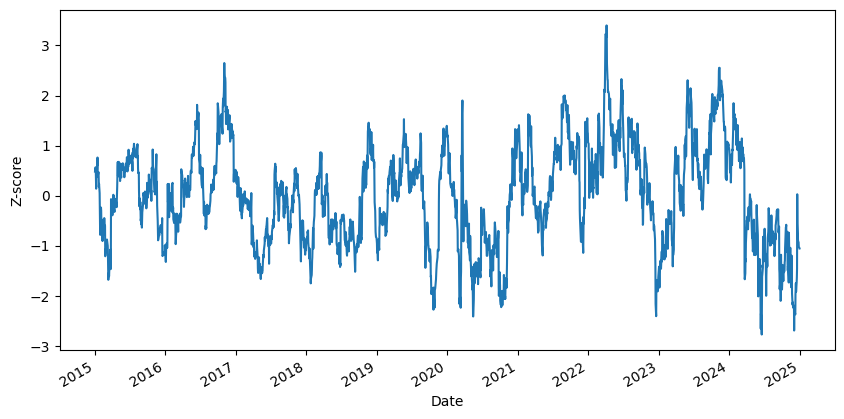

In [35]:
data = df_constant_z_score['ACN_HD_constant_z_score']
fig, ax = plt.subplots(figsize=(10, 5))
data.plot(ax=ax)
ax.xaxis.set_major_locator(mdates.YearLocator())  # Set ticks at the start of each year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as year (e.g., 2011, 2012, ...)
plt.ylabel('Z-score')
plt.xlabel('Date')

In [81]:
# Define thresholds from 1 to 4 in steps of 0.1
thresholds = [1.0 + 0.1 * i for i in range(21)]  # [1.0, 1.1, ..., 3.0]

In [82]:
# Function to compute final cumulative return for a given threshold
def compute_strategy_metrics(df, threshold, hedge_ratio):
    # Initialize position columns
    df['position_A'] = 0
    df['position_B'] = 0
    in_position = None
    trades = 0

    # Loop through data to set positions
    for i in range(1, len(df)):
        z = df['z_score'].iloc[i]

        if in_position is None:
            if z < -threshold:
                in_position = 'long'
                trades += 1
            elif z > threshold:
                in_position = 'short'
                trades += 1
        elif in_position == 'long':
            if z >= 0:
                in_position = None
        elif in_position == 'short':
            if z <= 0:
                in_position = None

        # Set positions using loc
        if in_position == 'long':
            df.loc[df.index[i], 'position_A'] = 1           # Long A
            df.loc[df.index[i], 'position_B'] = -hedge_ratio # Short B
        elif in_position == 'short':
            df.loc[df.index[i], 'position_A'] = -1          # Short A
            df.loc[df.index[i], 'position_B'] = hedge_ratio # Long B
        else:
            df.loc[df.index[i], 'position_A'] = 0
            df.loc[df.index[i], 'position_B'] = 0

    # Calculate strategy daily return
    df['strategy_daily_return'] = (df['position_A'].shift(1) * df['log_re_A'] + df['position_B'].shift(1) * df['log_re_B']).fillna(0)

    # Calculate cumulative return
    df['cumulative_return'] = df['strategy_daily_return'].cumsum()
    df['cumulative_return'] = df['cumulative_return'] * 100
    equity_curve = df['cumulative_return']

    # Return the final equity value
    final_return = df['cumulative_return'].iloc[-1]


    return final_return, trades, equity_curve


In [95]:
df_best_cum_return_num_trade = {"Pairs": [], "Max_Return": [], "Threshold": [], "Number_of_trade": []}
df_best_cum_return_num_trade = pd.DataFrame(df_best_cum_return_num_trade)
df_best_cum_return_num_trade

,Pairs,Max_Return,Threshold,Number_of_trade


In [23]:
for ticker1, ticker2 in constant_cointegrated_pairs:
    df_backtest = pd.concat([price_data[f"{ticker1}"], price_data[f"{ticker2}"]], axis=1)
    df_backtest['log_re_A'] = df_backtest[f"{ticker1}"] - df_backtest[f"{ticker1}"].shift(1)
    df_backtest['log_re_B'] = df_backtest[f"{ticker2}"] - df_backtest[f"{ticker2}"].shift(1)
    df_backtest['z_score'] = df_constant_z_score[f"{ticker1}_{ticker2}_constant_z_score"]
    hedge_ratio = constant_params[f"{ticker1}_{ticker2}_constant_hedge_ratio"].iloc[0]

    results = []
    for threshold in thresholds:
        final_return, trades, equity_curve = compute_strategy_metrics(df_backtest, threshold, hedge_ratio)
        results.append({
          'threshold': threshold,
          'final_cum_return': final_return,
          'trades': trades,
        })

    df_results = pd.DataFrame(results)

    length = len(df_best_cum_return_num_trade)
    df_best_cum_return_num_trade.loc[length, "Pairs"] = f"{ticker1}_{ticker2}"

    best_cum_return = df_results['final_cum_return'].max()
    df_best_cum_return_num_trade.loc[length, "Max_Return"] = best_cum_return

    best_idx = df_results['final_cum_return'].idxmax()
    best_threshold = df_results.loc[best_idx, 'threshold']
    df_best_cum_return_num_trade.loc[length, "Threshold"] = best_threshold

    best_number_trade = df_results.loc[best_idx, 'trades']
    df_best_cum_return_num_trade.loc[length, "Number_of_trade"] = best_number_trade

In [24]:
df_best_cum_return_num_trade

,Pairs,Max_Return,Threshold,Number_of_trade
0,ACN_HD,269.294096,1.3,25.0
1,A_MTD,174.855200,1.4,17.0
2,LNT_AEE,99.951244,1.0,20.0
3,LNT_CMS,64.538461,1.0,16.0
4,GOOGL_GOOG,16.820077,1.4,11.0
5,AEP_CMS,71.126131,1.0,15.0
6,AJG_LIN,259.692686,1.0,28.0
7,AJG_MMC,118.933799,1.3,13.0
8,AJG_SNPS,152.094000,1.2,13.0
9,AZO_ORLY,110.640568,1.0,10.0


In [27]:
df_best_cum_return_num_trade_sorted = df_best_cum_return_num_trade.sort_values(by='Max_Return', ascending=False)
df_best_cum_return_num_trade_sorted
# df_best_cum_return_num_trade_sorted.to_csv('df_best_cum_return_num_trade_sorted.csv')

,Pairs,Max_Return,Threshold,Number_of_trade
11,CDNS_LIN,336.804237,1.0,21.0
23,MPWR_SNPS,280.329353,1.1,16.0
27,MSCI_TMO,277.911257,1.1,18.0
0,ACN_HD,269.294096,1.3,25.0
15,CPRT_V,267.221341,1.0,18.0
6,AJG_LIN,259.692686,1.0,28.0
28,MSCI_ZTS,242.857951,1.5,13.0
25,MCO_NOW,241.442191,1.1,24.0
21,MA_ROP,232.876733,1.3,21.0
17,KLAC_SNPS,231.006855,1.1,15.0


**Example of CDNS vs LIN**

In [37]:
ticker1 = "CDNS"
ticker2 = "LIN"

Text(0.5, 1.0, 'Closing Prices')

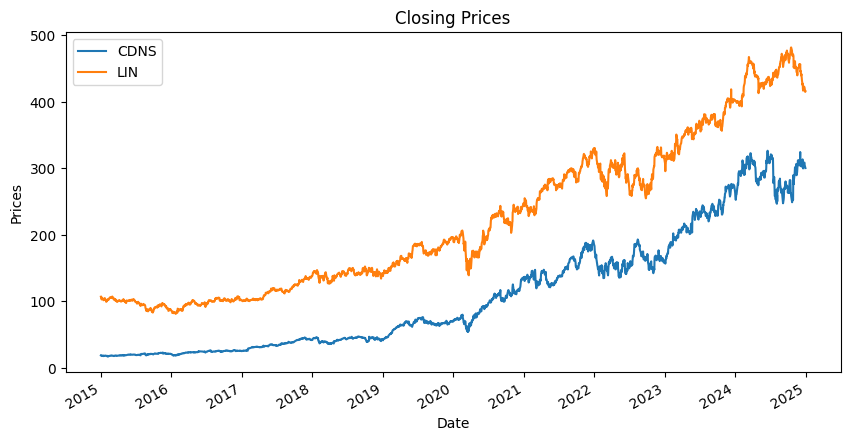

In [38]:
data = raw_price_data[[f"{ticker1}",f"{ticker2}"]]
fig, ax = plt.subplots(figsize=(10, 5))
data.plot(ax=ax)
ax.xaxis.set_major_locator(mdates.YearLocator())  # Set ticks at the start of each year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as year (e.g., 2011, 2012, ...)
plt.ylabel('Prices')
plt.xlabel('Date')
plt.title('Closing Prices')

Text(0.5, 0, 'Date')

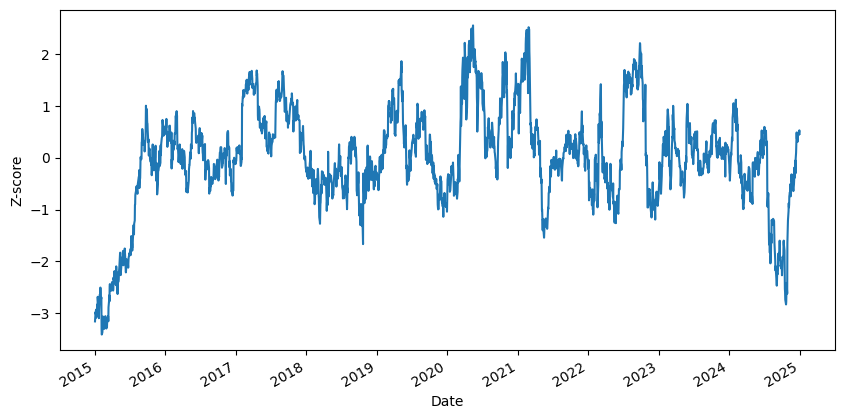

In [39]:
data = df_constant_z_score[f"{ticker1}_{ticker2}_constant_z_score"]
fig, ax = plt.subplots(figsize=(10, 5))
data.plot(ax=ax)
ax.xaxis.set_major_locator(mdates.YearLocator())  # Set ticks at the start of each year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as year (e.g., 2011, 2012, ...)
plt.ylabel('Z-score')
plt.xlabel('Date')

In [40]:
df_backtest = pd.concat([price_data[f"{ticker1}"], price_data[f"{ticker2}"]], axis=1)
df_backtest['log_re_A'] = df_backtest[f"{ticker1}"] - df_backtest[f"{ticker1}"].shift(1)
df_backtest['log_re_B'] = df_backtest[f"{ticker2}"] - df_backtest[f"{ticker2}"].shift(1)
df_backtest['z_score'] = df_constant_z_score[f"{ticker1}_{ticker2}_constant_z_score"]
hedge_ratio = constant_params[f"{ticker1}_{ticker2}_constant_hedge_ratio"].iloc[0]
df_backtest

,CDNS,LIN,log_re_A,log_re_B,z_score
Date,,,,,
2015-01-02,2.935451,4.673360,NaN,NaN,-3.159695
2015-01-05,2.912351,4.646610,-0.023101,-0.026749,-2.979865
2015-01-06,2.885359,4.633724,-0.026991,-0.012887,-3.019766
2015-01-07,2.913437,4.644870,0.028078,0.011146,-2.947510
2015-01-08,2.923699,4.661205,0.010262,0.016334,-3.087991
...,...,...,...,...,...
2024-12-24,5.731981,6.047385,0.013606,0.008112,0.445523
2024-12-26,5.732338,6.043973,0.000356,-0.003411,0.494803
2024-12-27,5.720410,6.040810,-0.011927,-0.003163,0.442710


In [42]:
results = []
for threshold in thresholds:
    final_return, trades = compute_strategy_metrics(df_backtest, threshold, hedge_ratio)
    results.append({
      'threshold': threshold,
      'final_cum_return': final_return,
      'trades': trades,
    })
df_results = pd.DataFrame(results)

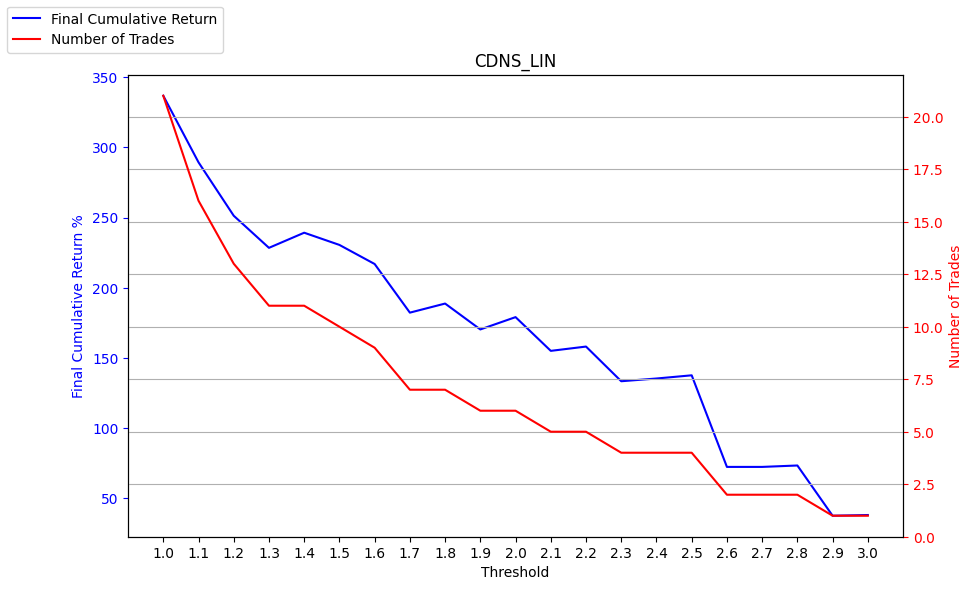

In [64]:
# Plot combo chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis: Final cumulative return
line1, = ax1.plot(df_results['threshold'], df_results['final_cum_return'], 'b-', label='Final Cumulative Return')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Final Cumulative Return %', color='b')
ax1.tick_params('y', colors='b')

# Right y-axis: Number of trades
ax2 = ax1.twinx()
line2, = ax2.plot(df_results['threshold'], df_results['trades'], 'r-', label='Number of Trades')
ax2.set_ylabel('Number of Trades', color='r')
ax2.tick_params('y', colors='r')

# Set x-axis ticks to thresholds
ax1.set_xticks(thresholds)

# Add legend
fig.legend([line1, line2], ['Final Cumulative Return', 'Number of Trades'], loc='upper left')

# Add title and grid
plt.title(f"{ticker1}_{ticker2}")
plt.grid(True)
plt.show()

In [103]:
start_date = "2015-01-01"
end_date = "2025-01-01"

benchmark_ticker = "SPY"
data = yf.download(benchmark_ticker, start=start_date, end=end_date, interval="1d", auto_adjust=True, multi_level_index=False)['Close']
data = data.apply(np.log)

benchmark = pd.DataFrame()
benchmark["Close"] = data

benchmark["log_re"] = benchmark["Close"] - benchmark["Close"].shift(1)
benchmark['cumulative_return'] = benchmark['log_re'].cumsum()
benchmark['cumulative_return'] = benchmark['cumulative_return'] * 100
benchmark

[*********************100%***********************]  1 of 1 completed


,Close,log_re,cumulative_return
Date,,,
2015-01-02,5.144980,NaN,NaN
2015-01-05,5.126755,-0.018224,-1.822448
2015-01-06,5.117292,-0.009464,-2.768817
2015-01-07,5.129676,0.012384,-1.530397
2015-01-08,5.147265,0.017590,0.228565
...,...,...,...
2024-12-24,6.393138,0.011054,124.815866
2024-12-26,6.393205,0.000067,124.822524
2024-12-27,6.382623,-0.010582,123.764284


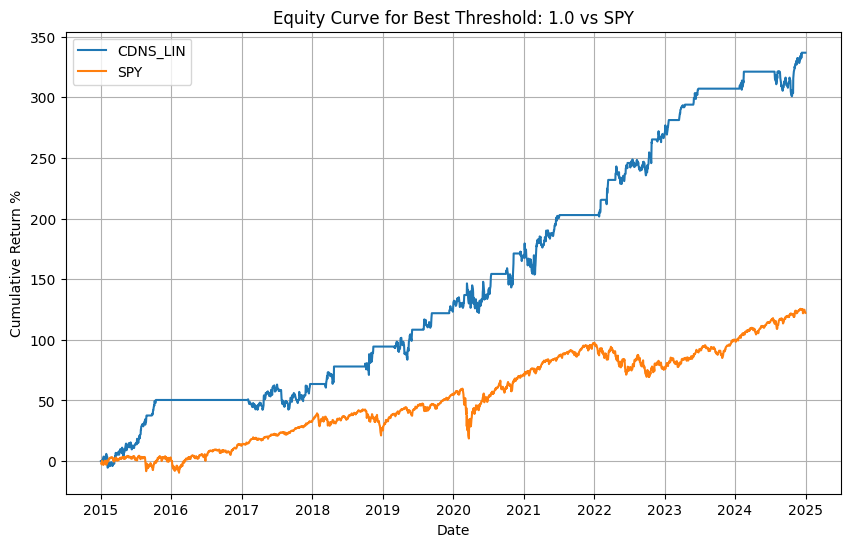

In [104]:
row_index = df_best_cum_return_num_trade_sorted[df_best_cum_return_num_trade_sorted['Pairs'] == f"{ticker1}_{ticker2}"].index
best_threshold = df_best_cum_return_num_trade_sorted.loc[row_index, 'Threshold'].iloc[0]

# Compute equity curve for the best threshold
_, _, equity_curve = compute_strategy_metrics(df_backtest, best_threshold, hedge_ratio)
df_backtest["cumulative_return"] = equity_curve

# Plot 2: Equity curve for the best threshold
plt.figure(figsize=(10, 6))
plt.plot(equity_curve, label=f"{ticker1}_{ticker2}")
plt.plot(benchmark['cumulative_return'], label=f"{benchmark_ticker}")
plt.xlabel('Date')
plt.ylabel('Cumulative Return %')
plt.title(f'Equity Curve for Best Threshold: {best_threshold:.1f} vs {benchmark_ticker}')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [62]:
df_backtest.to_csv(f"{ticker1}_{ticker2}_df_backtest.csv")